In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import os
import time

# --- 1. *** 关键 ***: GPU 初始化 (必须在最前面) ---
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        details = tf.config.experimental.get_device_details(gpus[0])
        print(f"🎉 成功检测到 GPU: {details.get('name', 'Unknown')}")

        # 在执行任何其他操作之前设置内存增长
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("     已为 GPU 设置 'set_memory_growth(True)'。")

    except RuntimeError as e:
        print(f"GPU 初始化时出错: {e}")
else:
    print("⚠️ 未检测到 GPU。")

TensorFlow Version: 2.19.0
🎉 成功检测到 GPU: Unknown
     已为 GPU 设置 'set_memory_growth(True)'。


In [ ]:
#运行2秒
print("\n--- 步骤 1: 定义受试者分割 ---")

TFRECORD_PATH = "/content/drive/MyDrive/MLSP/tfrecords_flexible/all_epochs.tfrecord"
if not os.path.exists(TFRECORD_PATH):
    raise FileNotFoundError(f"❌ 错误: 找不到 TFRecord 文件: {TFRECORD_PATH}")
else:
    print(f"将使用 TFRecord 文件: {TFRECORD_PATH}")

# B. 创建受试者 ID 列表
TOTAL_SUBJECTS = 197
subject_ids = np.arange(TOTAL_SUBJECTS)
TRAIN_SPLIT_PERCENT = 0.7
VAL_SPLIT_PERCENT = 0.15

train_val_ids, test_ids = train_test_split(
    subject_ids,
    test_size=(1 - TRAIN_SPLIT_PERCENT - VAL_SPLIT_PERCENT),
    random_state=42
)
val_size_relative = VAL_SPLIT_PERCENT / (TRAIN_SPLIT_PERCENT + VAL_SPLIT_PERCENT)
train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=val_size_relative,
    random_state=42
)
print(f"  -> 训练集受试者 (Train IDs): {len(train_ids)} 个")
print(f"  -> 验证集受试者 (Val IDs):   {len(val_ids)} 个")
print(f"  -> 测试集受试者 (Test IDs):    {len(test_ids)} 个")


# --- 3. *** 规避 BUG：创建 Python Set 用于过滤 *** ---
# 我们不再创建哈希表，而是创建 Python Set，以便快速查找
print("\n正在创建用于过滤的 Python Set...")
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
test_ids_set = set(test_ids)
print("Set 创建成功。")


--- 步骤 1: 定义受试者分割 ---
将使用 TFRecord 文件: /content/drive/MyDrive/MLSP/tfrecords_flexible/all_epochs.tfrecord
  -> 训练集受试者 (Train IDs): 137 个
  -> 验证集受试者 (Val IDs):   30 个
  -> 测试集受试者 (Test IDs):    30 个

正在创建用于过滤的 Python Set...
Set 创建成功。


In [ ]:
#运行200秒
print("\n--- 步骤 2: 开始计算类别权重 (使用 tf.py_function) ---")
from tqdm.notebook import tqdm
start_time = time.time()

# A. 定义一个 *轻量级* 的解析函数 (只解析 y 和 subject_id)
@tf.function
def parse_label_and_id_fn(example_proto):
    feature_description = {
        'y_label': tf.io.FixedLenFeature([], tf.int64),
        'subject_id': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    return tf.cast(example['y_label'], tf.int32), tf.cast(example['subject_id'], tf.int32)

# B. *** 规避 BUG: 定义 Python 过滤器 ***
def py_is_train(subject_id_tensor):
    return subject_id_tensor.numpy() in train_ids_set

@tf.function
def tf_is_train_filter(y_label, subject_id):
    is_in_set = tf.py_function(py_is_train, inp=[subject_id], Tout=tf.bool)
    return is_in_set

# C. 创建 tf.data 管道
dataset = tf.data.TFRecordDataset(TFRECORD_PATH, compression_type="GZIP")
dataset = dataset.map(parse_label_and_id_fn, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(tf_is_train_filter)
dataset = dataset.map(lambda y_label, subject_id: y_label)

# --- D. *** 修改：使用 TQDM 替换 np.fromiter *** ---
all_train_labels = []
print("正在迭代数据集以提取标签 (这可能需要几分钟)...")

# 使用 tqdm.notebook 来包装迭代器，显示进度条
# desc='...' 是进度条的描述
# unit=' epochs' 是计数单位
iterator = dataset.as_numpy_iterator()
for label in tqdm(iterator, desc="提取训练标签", unit=" epochs"):
    all_train_labels.append(label)

# 迭代完成后，才将列表转换为 Numpy 数组
all_train_labels = np.array(all_train_labels, dtype=np.int32)
end_time = time.time() # 将 end_time 移到循环之后
print(f"\n标签提取完毕！用时: {end_time - start_time:.2f} 秒。")
# --- 修改结束 ---

# E. 计算权重 (和之前一样)
print(f"已加载 {len(all_train_labels)} 个训练集 Epochs 的标签。")
label_counts = Counter(all_train_labels)
print("\n训练集中的标签分布 (Counts):")
print(f"  0 (W):   {label_counts.get(0, 0)}")
print(f"  1 (N1):  {label_counts.get(1, 0)}")
print(f"  2 (N2):  {label_counts.get(2, 0)}")
print(f"  3 (N3):  {label_counts.get(3, 0)}")
print(f"  4 (R):   {label_counts.get(4, 0)}")

class_labels = np.unique(all_train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=all_train_labels
)

# F. 保存最终的权重字典
class_weight_dict = dict(zip(class_labels, class_weights))

print("\n计算得到的类别权重 (用于 model.fit):")
print(class_weight_dict)
print("-" * 30)


--- 步骤 2: 开始计算类别权重 (使用 tf.py_function) ---
正在迭代数据集以提取标签 (这可能需要几分钟)...


提取训练标签: 0 epochs [00:00, ? epochs/s]


标签提取完毕！用时: 211.50 秒。
已加载 317611 个训练集 Epochs 的标签。

训练集中的标签分布 (Counts):
  0 (W):   200663
  1 (N1):  17998
  2 (N2):  62117
  3 (N3):  13036
  4 (R):   23797

计算得到的类别权重 (用于 model.fit):
{np.int32(0): np.float64(0.3165615983016301), np.int32(1): np.float64(3.5294032670296698), np.int32(2): np.float64(1.0226218265531175), np.int32(3): np.float64(4.872829088677508), np.int32(4): np.float64(2.6693364709837373)}
------------------------------


In [ ]:
# 步骤三 创建 Keras 数据生成器 运行1秒
if 'TFRECORD_PATH' not in locals():
    print("❌ 错误: 变量 'TFRECORD_PATH' 未定义。")
    # 设置一个默认值以防万一，但您应该检查您的路径
    TFRECORD_PATH = "/content/drive/MyDrive/mspl project/tfrecords_flexible/all_epochs.tfrecord"

if 'train_ids_set' not in locals():
    print("❌ 错误: 变量 'train_ids_set' 和 'val_ids_set' 未定义。")
    # 模拟空值，但这会导致错误
    train_ids_set = set()
    val_ids_set = set()

# 定义批次大小和预取缓冲区
BATCH_SIZE = 64  # A100 可以轻松处理 64 或 128
AUTOTUNE = tf.data.AUTOTUNE # 让 TF 自动优化并行度
SHUFFLE_BUFFER_SIZE = 10000 # 缓冲区大小，用于打乱 Epochs

print(f"--- 步骤 3：创建数据管道 ---")
print(f"Batch Size: {BATCH_SIZE}")
print(f"TFRecord 文件: {TFRECORD_PATH}")


# --- 2. 定义 *完整* 的解析函数 ---
# (这个函数需要解析 X, y, 和 subject_id)
@tf.function
def parse_tfrecord_fn_full(example_proto):
    feature_description = {
        'x_data': tf.io.FixedLenFeature([], tf.string),     # 序列化的 numpy 字节
        'y_label': tf.io.FixedLenFeature([], tf.int64),    # 单个整数
        'subject_id': tf.io.FixedLenFeature([], tf.int64) # 受试者 ID
    }

    # 解析 proto
    example = tf.io.parse_single_example(example_proto, feature_description)

    # --- 反序列化 ---
    # 1. 解码 X (信号)
    x_bytes = example['x_data']
    x = tf.io.decode_raw(x_bytes, tf.float32)
    # 恢复原始形状 (2 通道, 3000 时间点)
    x = tf.reshape(x, [2, 3000])

    # 2. 解码 y (标签)
    y = tf.cast(example['y_label'], tf.int32)

    # 3. 解码 subject_id
    subject_id = tf.cast(example['subject_id'], tf.int32)

    # 返回 (x, y) 作为模型的特征和标签，subject_id 用于过滤
    return (x, y), subject_id


# --- 3. 定义 *规避 BUG* 的 Python 过滤器 ---

# (这些函数利用了在上一个单元格中创建的 'train_ids_set' 和 'val_ids_set')
def py_is_train(subject_id_tensor):
    return subject_id_tensor.numpy() in train_ids_set

@tf.function
def tf_is_train_filter(features, subject_id):
    # 'features' 在这里是 (x, y) 元组
    is_in_set = tf.py_function(py_is_train, inp=[subject_id], Tout=tf.bool)
    return is_in_set

def py_is_val(subject_id_tensor):
    return subject_id_tensor.numpy() in val_ids_set

@tf.function
def tf_is_val_filter(features, subject_id):
    is_in_set = tf.py_function(py_is_val, inp=[subject_id], Tout=tf.bool)
    return is_in_set

def normalize_epoch(features, subject_id):
    """
    对每个 Epoch (x, y) 中的 x 进行 Z-Score 归一化
    """
    x, y = features

    # 1. 计算每个通道 (axis=1) 的均值和标准差
    mean = tf.math.reduce_mean(x, axis=1, keepdims=True)
    std = tf.math.reduce_std(x, axis=1, keepdims=True)

    # 2. 归一化: (x - mean) / (std + 1e-6)
    x_normalized = (x - mean) / (std + 1e-6)

    # 3. 返回归一化后的数据
    return (x_normalized, y), subject_id
# --- 4. 创建数据管道的“工厂”函数 (核心) ---

def create_dataset(filter_func, batch_size, shuffle=True):
    dataset = tf.data.TFRecordDataset(TFRECORD_PATH, compression_type="GZIP")

    # *** 关键修复：将 .map() 放在 .cache() 之前 ***
    # 这样我们缓存的是“已解析”的数据，极大提高后续 Epoch 的速度
    dataset = dataset.map(parse_tfrecord_fn_full, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()

    dataset = dataset.filter(filter_func)
    dataset = dataset.map(normalize_epoch, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda features, subject_id: features, num_parallel_calls=AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset
# --- 5. 实例化您的数据管道 ---

print("\n正在实例化 'train_dataset'...")
# 使用 训练集过滤器，并开启 Shuffle
train_dataset = create_dataset(
    filter_func=tf_is_train_filter,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("正在实例化 'val_dataset'...")
# 使用 验证集过滤器，并关闭 Shuffle (验证时不需要)
val_dataset = create_dataset(
    filter_func=tf_is_val_filter,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\n--- 🎉 步骤 3 完成！ ---")
print("您现在拥有了 'train_dataset' 和 'val_dataset' 变量。")
print("下一步是定义您的 Keras 模型 (步骤 4)。")

--- 步骤 3：创建数据管道 ---
Batch Size: 64
TFRecord 文件: /content/drive/MyDrive/MLSP/tfrecords_flexible/all_epochs.tfrecord

正在实例化 'train_dataset'...
正在实例化 'val_dataset'...

--- 🎉 步骤 3 完成！ ---
您现在拥有了 'train_dataset' 和 'val_dataset' 变量。
下一步是定义您的 Keras 模型 (步骤 4)。


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    MultiHeadAttention, Embedding, Permute, Reshape,
    Add, BatchNormalization, ReLU
)

# --- 配置参数 ---
INPUT_SHAPE = (2, 3000)  # (channels, time_steps)
NUM_CLASSES = 5
PATCH_SIZE = 30          # 每个 patch 包含 30 个时间点 (0.3秒)
D_MODEL = 128            # Transformer 隐藏维度
NUM_HEADS = 8            # 注意力头数
NUM_TRANSFORMER_BLOCKS = 4
FF_DIM = 256             # 前馈网络维度
DROPOUT_RATE = 0.2


# --- 1. Patch Embedding 层 ---
class PatchEmbedding(tf.keras.layers.Layer):
    """
    将 EEG 信号分割成 patches 并嵌入到高维空间
    类似于 ViT 中的图像 patch embedding
    """
    def __init__(self, patch_size, d_model, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model

    def build(self, input_shape):
        # input_shape: (batch, time_steps, channels)
        self.num_patches = input_shape[1] // self.patch_size

        # 用 Conv1D 来做 patch embedding (更高效)
        self.projection = Conv1D(
            filters=self.d_model,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding='valid'
        )

        # 可学习的位置编码
        self.position_embedding = self.add_weight(
            name='position_embedding',
            shape=(1, self.num_patches, self.d_model),
            initializer='random_normal',
            trainable=True
        )

        # 可学习的 [CLS] token
        self.cls_token = self.add_weight(
            name='cls_token',
            shape=(1, 1, self.d_model),
            initializer='random_normal',
            trainable=True
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # 线性投影每个 patch
        x = self.projection(x)  # (batch, num_patches, d_model)

        # 添加位置编码
        x = x + self.position_embedding

        # 添加 [CLS] token
        cls_tokens = tf.tile(self.cls_token, [batch_size, 1, 1])
        x = tf.concat([cls_tokens, x], axis=1)  # (batch, num_patches+1, d_model)

        return x


# --- 2. Transformer Encoder Block ---
class TransformerBlock(tf.keras.layers.Layer):
    """
    标准 Transformer Encoder Block
    包含: Multi-Head Attention + Feed-Forward Network
    """
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

    def build(self, input_shape):
        # Multi-Head Self-Attention
        self.mha = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model // self.num_heads,
            dropout=self.dropout_rate
        )

        # Feed-Forward Network
        self.ffn = tf.keras.Sequential([
            Dense(self.ff_dim, activation='gelu'),
            Dropout(self.dropout_rate),
            Dense(self.d_model),
            Dropout(self.dropout_rate)
        ])

        # Layer Normalization (Pre-LN 架构，更稳定)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)

        # Dropout
        self.dropout1 = Dropout(self.dropout_rate)

    def call(self, x, training=False):
        # Pre-LN Self-Attention
        x_norm = self.ln1(x)
        attn_output = self.mha(x_norm, x_norm, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        x = x + attn_output  # 残差连接

        # Pre-LN Feed-Forward
        x_norm = self.ln2(x)
        ffn_output = self.ffn(x_norm, training=training)
        x = x + ffn_output  # 残差连接

        return x


# --- 3. CNN Feature Extractor (可选的前端) ---
def cnn_frontend(x):
    """
    用浅层 CNN 先提取局部特征，再送入 Transformer
    这对于 EEG 这类高频信号很有帮助
    """
    # Block 1: 提取低频特征
    x = Conv1D(64, kernel_size=50, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.1)(x)

    # Block 2: 提取中频特征
    x = Conv1D(128, kernel_size=10, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.1)(x)

    return x  # 输出形状约: (batch, 375, 128)


# --- 4. 构建完整的 Sleep Transformer 模型 ---
def build_sleep_transformer(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    use_cnn_frontend=True,
    patch_size=PATCH_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_blocks=NUM_TRANSFORMER_BLOCKS,
    ff_dim=FF_DIM,
    dropout=DROPOUT_RATE
):
    """
    构建 Sleep Stage Classification Transformer

    架构:
    Input (2, 3000)
        → Permute (3000, 2)
        → [可选] CNN Frontend (提取局部特征)
        → Patch Embedding + Positional Encoding + [CLS] Token
        → N x Transformer Blocks
        → [CLS] Token 输出
        → Classification Head
        → 5 类 Softmax
    """

    # 输入层
    inputs = Input(shape=input_shape)

    # 维度转换: (batch, 2, 3000) → (batch, 3000, 2)
    x = Permute((2, 1))(inputs)

    if use_cnn_frontend:
        # 使用 CNN 前端提取局部特征
        x = cnn_frontend(x)
        # 此时 x 形状约为 (batch, ~375, 128)
        # 调整 patch_size 适应 CNN 输出
        actual_patch_size = 5  # CNN 输出后用较小的 patch
    else:
        # 直接用原始信号
        actual_patch_size = patch_size

    # Patch Embedding
    x = PatchEmbedding(actual_patch_size, d_model)(x)

    # Transformer Encoder Blocks
    for i in range(num_blocks):
        x = TransformerBlock(
            d_model=d_model,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            name=f'transformer_block_{i}'
        )(x)

    # 最终 Layer Normalization
    x = LayerNormalization(epsilon=1e-6)(x)

    # 提取 [CLS] token 作为全局表示
    cls_output = x[:, 0, :]  # (batch, d_model)

    # 分类头
    x = Dense(64, activation='gelu')(cls_output)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# --- 5. 构建模型并打印摘要 ---
print("=" * 50)
print("🚀 构建 Sleep Stage Transformer 模型")
print("=" * 50)

model = build_sleep_transformer(
    use_cnn_frontend=True,  # 推荐开启，对 EEG 效果更好
    d_model=128,
    num_heads=8,
    num_blocks=4,
    ff_dim=256,
    dropout=0.2
)

print("\n--- 模型架构摘要 ---")
model.summary()


# --- 6. 编译模型 ---
print("\n--- 编译模型 ---")

# 使用学习率调度 (Warmup + Cosine Decay)
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step + 1)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 或者用简单的 Adam
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ 模型编译完成!")
print(f"   优化器: Adam (lr=1e-4)")
print(f"   损失函数: sparse_categorical_crossentropy")


# --- 7. 训练配置 (回调函数) ---
print("\n--- 训练配置 ---")

# 假设 CHECKPOINT_DIR 已定义
CHECKPOINT_DIR = "/content/drive/MyDrive/MLSP/checkpoints_transformer/"

import os
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

callbacks = [
    # 保存最佳模型
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, "best_model.weights.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    ),

    # 学习率衰减
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # 早停
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )
]

print("✅ 回调函数配置完成!")
print("   - ModelCheckpoint (保存最佳验证准确率)")
print("   - ReduceLROnPlateau (学习率衰减)")
print("   - EarlyStopping (早停, patience=10)")


# --- 8. 开始训练 ---
print("\n" + "=" * 50)
print("开始训练 (确保已运行数据准备代码)")
print("=" * 50)

# 取消注释以下代码开始训练:
"""
NUM_EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight_dict,  # 使用之前计算的类别权重
    callbacks=callbacks
)

print("\n🎉 训练完成!")
"""

print("\n📌 提示: 取消注释上面的 model.fit() 代码块开始训练")
print("📌 建议: NUM_EPOCHS=30, 配合 EarlyStopping")

🚀 构建 Sleep Stage Transformer 模型

--- 模型架构摘要 ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2, 3000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 3000, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1500, 64)       │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 750, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 750, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 750, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 375, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 375, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, 76, 128)        │        91,776 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ (None, 76, 128)        │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 76, 128)        │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 76, 128)        │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 76, 128)        │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 76, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             

 Total params: 719,813 (2.75 MB)

 Trainable params: 719,429 (2.74 MB)

 Non-trainable params: 384 (1.50 KB)


--- 编译模型 ---
✅ 模型编译完成!
   优化器: Adam (lr=1e-4)
   损失函数: sparse_categorical_crossentropy

--- 训练配置 ---
✅ 回调函数配置完成!
   - ModelCheckpoint (保存最佳验证准确率)
   - ReduceLROnPlateau (学习率衰减)
   - EarlyStopping (早停, patience=10)

开始训练 (确保已运行数据准备代码)

📌 提示: 取消注释上面的 model.fit() 代码块开始训练
📌 建议: NUM_EPOCHS=30, 配合 EarlyStopping


In [ ]:
# ========================================
# 步骤 6: 训练 Transformer 模型
# ========================================

print("=" * 60)
print("🚀 开始训练 Sleep Stage Transformer")
print("=" * 60)

# --- 训练参数 ---
NUM_EPOCHS = 30  # Transformer 通常需要更多 epochs 才能收敛

# --- 检查必要变量 ---
required_vars = {
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'class_weight_dict': class_weight_dict,
    'callbacks': callbacks
}

print("\n✅ 检查训练环境...")
for var_name, var_value in required_vars.items():
    if var_value is None:
        print(f"❌ 错误: {var_name} 未定义")
    else:
        print(f"✅ {var_name} 已就绪")

# --- 开始训练 ---
print(f"\n📊 训练配置:")
print(f"   - Epochs: {NUM_EPOCHS}")
print(f"   - 使用类别权重: {list(class_weight_dict.keys())}")
print(f"   - Callbacks: {len(callbacks)} 个")
print(f"\n{'='*60}")
print("⏳ 训练中... (A100 GPU 加速)")
print("=" * 60)

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

print("\n" + "=" * 60)
print("🎉 训练完成！")
print("=" * 60)

# --- 打印训练结果摘要 ---
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 最终结果:")
print(f"   训练集准确率: {final_train_acc*100:.2f}%")
print(f"   验证集准确率: {final_val_acc*100:.2f}%")
print(f"   训练集损失:   {final_train_loss:.4f}")
print(f"   验证集损失:   {final_val_loss:.4f}")
print(f"\n💾 最佳模型已保存到: {CHECKPOINT_DIR}")

🚀 开始训练 Sleep Stage Transformer

✅ 检查训练环境...
✅ train_dataset 已就绪
✅ val_dataset 已就绪
✅ class_weight_dict 已就绪
✅ callbacks 已就绪

📊 训练配置:
   - Epochs: 30
   - 使用类别权重: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
   - Callbacks: 3 个

⏳ 训练中... (A100 GPU 加速)
Epoch 1/30
   4963/Unknown 265s 42ms/step - accuracy: 0.7970 - loss: 0.6708

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.80711, saving model to /content/drive/MyDrive/MLSP/checkpoints_transformer/best_model.weights.h5
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 411s 72ms/step - accuracy: 0.7970 - loss: 0.6708 - val_accuracy: 0.8071 - val_loss: 0.4678 - learning_rate: 1.0000e-04
Epoch 2/30
4962/4963 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8828 - loss: 0.4242
Epoch 2: val_accuracy improved from 0.80711 to 0.82911, saving model to /content/drive/MyDrive/MLSP/checkpoints_transformer/best_model.weights.h5
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 281s 56ms/step - accuracy: 0.8828 - loss: 0.4242 - val_accuracy: 0.8291 - val_loss: 0.4647 - learning_rate: 1.0000e-04
Epoch 3/30
4960/4963 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8890 - loss: 0.4031
Epoch 3: val_accuracy improved from 0.82911 to 0.83579, saving model to /content/drive/MyDrive/MLSP/checkpoints_transformer/best_model.weights.h5
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 280s 56ms/step - accuracy: 0.8889 - loss: 0.4032 - val_

📊 可视化训练历史


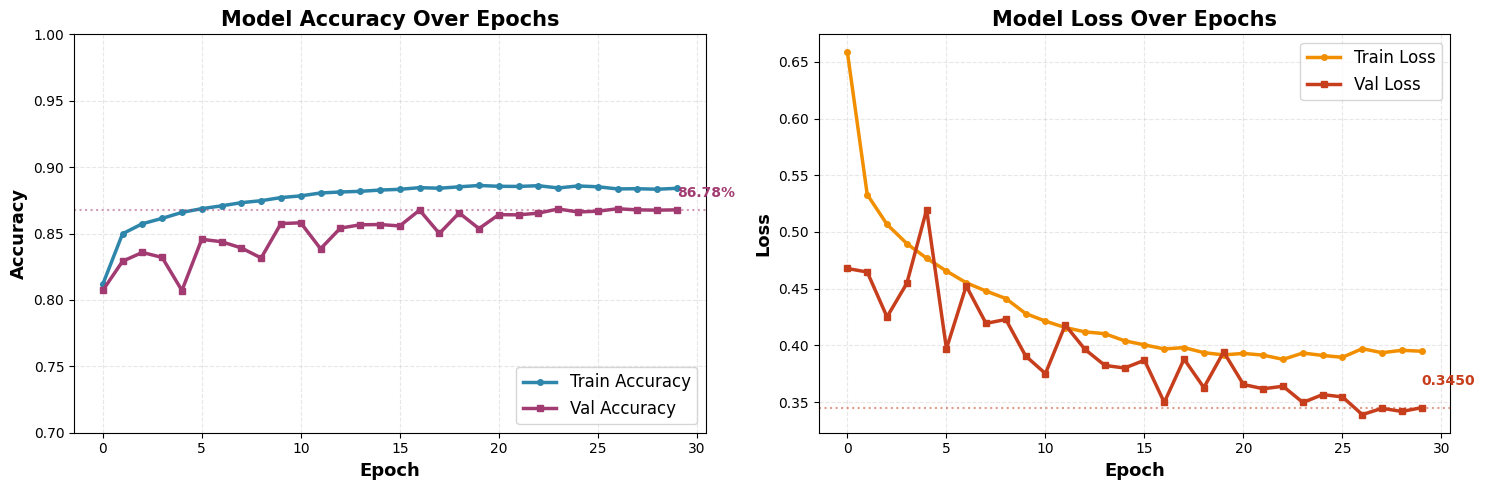


✅ 训练历史可视化完成!
   最终训练准确率: 88.40%
   最终验证准确率: 86.78%
   最终训练损失: 0.3948
   最终验证损失: 0.3450

🧪 在测试集上评估模型

⏳ 正在创建测试集数据管道...
✅ 测试集创建完成!

⏳ 正在评估测试集...
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 144s 127ms/step - accuracy: 0.8967 - loss: 0.2733

🎯 测试集结果:
   准确率: 85.79%
   损失:   0.3813

📊 生成混淆矩阵和分类报告

⏳ 正在收集预测结果...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ 收集完成！共 68890 个测试样本


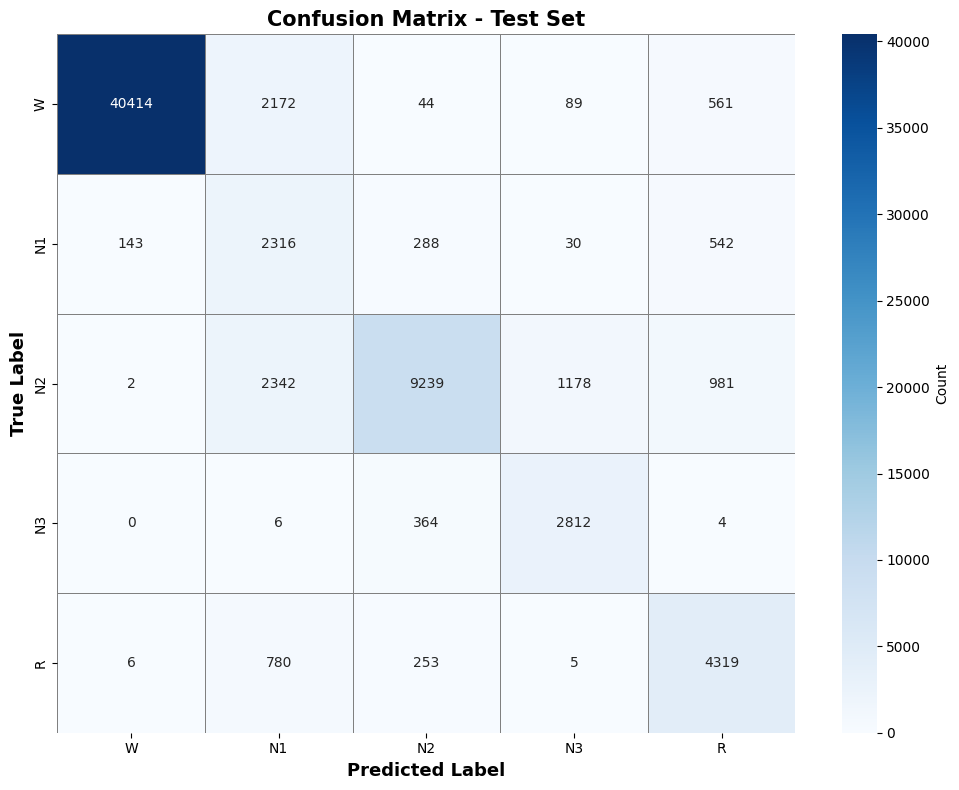


✅ 混淆矩阵生成完成!

📋 详细分类报告 (每个类别的 Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           W     0.9963    0.9338    0.9640     43280
          N1     0.3041    0.6978    0.4236      3319
          N2     0.9069    0.6723    0.7722     13742
          N3     0.6835    0.8826    0.7704      3186
           R     0.6741    0.8053    0.7339      5363

    accuracy                         0.8579     68890
   macro avg     0.7130    0.7984    0.7328     68890
weighted avg     0.9055    0.8579    0.8728     68890


🎯 各睡眠阶段的分类准确率
   W   (类别 0):  93.38% (43280 个样本)
   N1  (类别 1):  69.78% (3319 个样本)
   N2  (类别 2):  67.23% (13742 个样本)
   N3  (类别 3):  88.26% (3186 个样本)
   R   (类别 4):  80.53% (5363 个样本)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ========================================
# Part 1: 可视化训练历史（Loss 和 Accuracy）
# ========================================

print("=" * 60)
print("📊 可视化训练历史")
print("=" * 60)

# 设置中文字体（避免中文显示为方块）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- 子图 1: 准确率曲线 ---
axes[0].plot(history.history['accuracy'],
             label='Train Accuracy',
             linewidth=2.5,
             marker='o',
             markersize=4,
             color='#2E86AB')
axes[0].plot(history.history['val_accuracy'],
             label='Val Accuracy',
             linewidth=2.5,
             marker='s',
             markersize=4,
             color='#A23B72')
axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12, loc='lower right')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0.7, 1.0])  # 设置 y 轴范围

# 标注最终准确率
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
axes[0].axhline(y=final_val_acc, color='#A23B72', linestyle=':', alpha=0.5)
axes[0].text(len(history.history['accuracy'])-1, final_val_acc + 0.01,
             f'{final_val_acc*100:.2f}%',
             fontsize=10, color='#A23B72', fontweight='bold')

# --- 子图 2: 损失曲线 ---
axes[1].plot(history.history['loss'],
             label='Train Loss',
             linewidth=2.5,
             marker='o',
             markersize=4,
             color='#F18F01')
axes[1].plot(history.history['val_loss'],
             label='Val Loss',
             linewidth=2.5,
             marker='s',
             markersize=4,
             color='#C73E1D')
axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=13, fontweight='bold')
axes[1].set_title('Model Loss Over Epochs', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=12, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

# 标注最终损失
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
axes[1].axhline(y=final_val_loss, color='#C73E1D', linestyle=':', alpha=0.5)
axes[1].text(len(history.history['loss'])-1, final_val_loss + 0.02,
             f'{final_val_loss:.4f}',
             fontsize=10, color='#C73E1D', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ 训练历史可视化完成!")
print(f"   最终训练准确率: {final_train_acc*100:.2f}%")
print(f"   最终验证准确率: {final_val_acc*100:.2f}%")
print(f"   最终训练损失: {final_train_loss:.4f}")
print(f"   最终验证损失: {final_val_loss:.4f}")


# ========================================
# Part 2: 在测试集上评估
# ========================================

print("\n" + "=" * 60)
print("🧪 在测试集上评估模型")
print("=" * 60)

# --- 创建测试集数据管道 ---
def py_is_test(subject_id_tensor):
    return subject_id_tensor.numpy() in test_ids_set

@tf.function
def tf_is_test_filter(features, subject_id):
    is_in_set = tf.py_function(py_is_test, inp=[subject_id], Tout=tf.bool)
    return is_in_set

print("\n⏳ 正在创建测试集数据管道...")
test_dataset = create_dataset(
    filter_func=tf_is_test_filter,
    batch_size=64,
    shuffle=False
)
print("✅ 测试集创建完成!")

# --- 评估测试集 ---
print("\n⏳ 正在评估测试集...")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print("\n" + "=" * 60)
print("🎯 测试集结果:")
print(f"   准确率: {test_accuracy*100:.2f}%")
print(f"   损失:   {test_loss:.4f}")
print("=" * 60)


# ========================================
# Part 3: 生成混淆矩阵和详细分类报告
# ========================================

print("\n" + "=" * 60)
print("📊 生成混淆矩阵和分类报告")
print("=" * 60)

# --- 收集所有预测和真实标签 ---
print("\n⏳ 正在收集预测结果...")
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    predictions = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"✅ 收集完成！共 {len(y_true)} 个测试样本")

# --- 计算混淆矩阵 ---
cm = confusion_matrix(y_true, y_pred)
class_names = ['W', 'N1', 'N2', 'N3', 'R']

# --- 可视化混淆矩阵 ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ 混淆矩阵生成完成!")

# --- 打印详细分类报告 ---
print("\n" + "=" * 60)
print("📋 详细分类报告 (每个类别的 Precision, Recall, F1-Score)")
print("=" * 60)
print(classification_report(y_true, y_pred,
                           target_names=class_names,
                           digits=4))

# --- 计算每个类别的准确率 ---
print("\n" + "=" * 60)
print("🎯 各睡眠阶段的分类准确率")
print("=" * 60)

for i, class_name in enumerate(class_names):
    class_mask = (y_true == i)
    if class_mask.sum() > 0:
        class_accuracy = (y_pred[class_mask] == i).sum() / class_mask.sum()
        print(f"   {class_name:3s} (类别 {i}): {class_accuracy*100:6.2f}% "
              f"({class_mask.sum()} 个样本)")
    else:
        print(f"   {class_name:3s} (类别 {i}): 无样本")
